In [1]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))


/home/ubuntu/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:519: 

TensorFlow version: 1.14.0
Eager execution: True


In [2]:
#Parsing the Data
def parse_csv(line):
    example_defaults = [[0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0]] #set field types
    parsed_line = tf.decode_csv(line, example_defaults)
    #First 4 fields are feasture, combine into single tensor
    features = tf.reshape(parsed_line[:-1], shape=(30,))
    # Last field is the label
    label = tf.reshape(parsed_line[-1], shape=())
    return features, label

In [3]:
#Setting up the training data

train_dataset = tf.data.TextLineDataset("/home/ubuntu/dataset/Phishing_Dataset/phishing_data.csv")
train_dataset = train_dataset.skip(1) #skip the first header row
train_dataset = train_dataset.map(parse_csv) #parse each row
train_dataset = train_dataset.shuffle(buffer_size=20000) #randomize
train_dataset = train_dataset.batch(100)

#View a single example entry from a batch
features, label = tfe.Iterator(train_dataset).next()
print("example features:", features[0])
print("example label:", label[0])

example features: tf.Tensor(
[ 1.  1.  1.  1.  1. -1.  0. -1. -1. -1.  1.  1.  1.  0.  0.  1. -1.  1.
  0. -1.  1. -1.  1. -1. -1.  1. -1.  1.  0.  1.], shape=(30,), dtype=float32)
example label: tf.Tensor(1, shape=(), dtype=int32)


In [4]:
#Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, activation="relu", input_shape=(30,)),
    tf.keras.layers.Dense(500, activation="relu"),
    tf.keras.layers.Dense(2)
])

In [5]:
#Defining the loss and gradient functions 
def loss(model, x, y):
    y_ =  model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

def grad(model , inputs, targets):
    with tfe.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, model.variables)

In [6]:
#Setting the optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.01)

In [7]:


#Training the data
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()
    
    # Training loop - using batches of 32
  for x, y in tfe.Iterator(train_dataset):
        #optimize the model
    grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.variables),
                                 global_step=tf.train.get_or_create_global_step())
        
        #Track progress
    epoch_loss_avg(loss(model, x , y)) #add current batch loss
        # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

    

    #end epoc
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
    
  if epoch % 50 == 0:
   print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                   epoch_loss_avg.result(),
                                                                   epoch_accuracy.result()))
    

Epoch 000: Loss: 0.485, Accuracy: 84.803%
Epoch 050: Loss: 0.124, Accuracy: 94.923%
Epoch 100: Loss: 0.085, Accuracy: 96.721%
Epoch 150: Loss: 0.060, Accuracy: 98.010%
Epoch 200: Loss: 0.045, Accuracy: 98.688%


In [8]:
#Setting up the testing data 

test_dataset = tf.data.TextLineDataset("/home/ubuntu/dataset/Phishing_Dataset/phishing_data_test.csv")
test_dataset = test_dataset.skip(1) #skip the first header row
test_dataset = test_dataset.map(parse_csv) #parse each row
test_dataset = test_dataset.shuffle(buffer_size=20000) #randomize
test_dataset = test_dataset.batch(100)

#View a single example entry from a batch
features, label = tfe.Iterator(test_dataset).next()
print("example features:", features[0])
print("example label:", label[0])

example features: tf.Tensor(
[-1.  1.  1.  1.  1. -1. -1. -1. -1.  1.  1.  1.  1. -1.  0. -1.  1.  1.
  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  1.], shape=(30,), dtype=float32)
example label: tf.Tensor(0, shape=(), dtype=int32)


In [9]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    print(y_actual)
    print(y_hat)
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    return(TP, FP, TN, FN)

Using TensorFlow backend.


tf.Tensor(
[0 1 1 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 0
 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 1
 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0], shape=(100,), dtype=int32)
tf.Tensor(
[0 1 1 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 0
 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1
 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0], shape=(100,), dtype=int32)
tf.Tensor(
[1 0 0 0 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 0 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 0
 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0
 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1], shape=(100,), dtype=int32)
tf.Tensor(
[1 0 1 0 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 0
 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0
 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 0 0 0 0 1 0 1 0 1], shape=(100,), dtype=int32)
tf.Tensor(
[0 1 0 0 0 0 1 1 

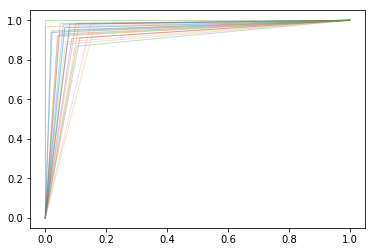

In [10]:
#############################################################################
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
from sklearn.metrics import roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt
import numpy as np

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i=0
#############################################################################


#Applying the model onto the test data
test_accuracy = tfe.metrics.Accuracy()


for (x, y) in tfe.Iterator(test_dataset):
    prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
    test_accuracy(prediction, y)
    #true_positive = tf.metrics.true_positives(y, prediction)
    #true_negative = tf.metrics.true_negatives(y, prediction)
#############################################################################
    TP, FP, TN, FN = perf_measure(y, prediction)
    true_positive = TP
    true_negative = TN
    
    #predictions = model.predict(x)
    fpr, tpr, thresholds = roc_curve(y, prediction)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i += 1
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
#############################################################################

# print("Test set accuracy: {:.3%}".format(test_accuracy.result()))
# print("Test true positive rate: {:3%").format(true_positive.result())
# print("Test test positive rate: {:3%").format(test_negative.result())

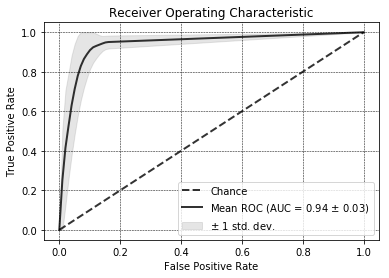

In [11]:
%matplotlib inline
#########################################################################
# Plot ROC
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='k',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(which='major', linestyle='--', linewidth='0.5', color='black')
#plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.savefig('ROC_all_malicious.png')
plt.show()